# Look at bathymetry from variety of sources in the Amundsen Sea sector

In [2]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cmocean
import pickle

#### Functions

In [3]:
def plot_Amundsen(depth_level, month):

    fig, ax = plt.subplots(1,1, figsize=(18,10), subplot_kw={'projection': ccrs.Mercator(latitude_true_scale=-70)})

    for axis in ax.ravel():
        axis.set_extent([-90, -160, -78, -64], ccrs.PlateCarree())
        cs = axis.contour(SOSE_sal_jan.XC, SOSE_sal_jan.YC, SOSE_sal_jan.Depth, levels=[1000, 2000], 
                          colors='w', linestyles='-', linewidths=1, zorder=4, transform=ccrs.PlateCarree())
        gl = axis.gridlines(draw_labels=True);
        gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;
    
    #----------------------------- WOA18 -----------------------------
    fig.text(1, 1.1, f'WOA18: January 1955-2017 climatology, depth: {WOA_temp.depth.values} m', 
             fontweight='bold', transform=ax[0,0].transAxes);
    
    cm1 = ax[0,0].pcolormesh(WOA_sal.lon, WOA_sal.lat, WOA_sal.s_an.isel(time=0), 
                             transform=ccrs.PlateCarree(), vmin=31, vmax=34)
    CB1 = fig.colorbar(cm1, ax=ax[0,0], fraction=0.03, label='Sea water salinity at standard depths (g/kg)')
    
    cm2 = ax[0,1].pcolormesh(WOA_temp.lon, WOA_temp.lat, WOA_temp.t_an.isel(time=0), 
                           transform=ccrs.PlateCarree(), vmin=-2, vmax=2)
    CB2 = fig.colorbar(cm2, ax=ax[0,1], fraction=0.03, label='Sea water temperature at standard depths (degC)')

    return fig

### Bathymetry

In [5]:
TERRA  = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/'
TERRA2 = '/gws/nopw/j04/terrafirma/kaight/input_data/topo/'

In [25]:
coord      = xr.open_dataset('/home/users/birgal/data/bathymetry/coordinates_AIS.nc').isel(y=slice(0,439))
BedMachine = xr.open_dataset('/home/users/birgal/data/bathymetry/eORCA025_BedMachine3_AIS.nc').isel(y=slice(0,439))
IBCSOv2    = xr.open_dataset('/home/users/birgal/data/bathymetry/topo/IBCSO_v2_bed_WGS84.nc').sel(lon=slice(-165,-85), lat=slice(-79,-64))
GEBCO      = xr.open_dataset(f'{TERRA2}GEBCO_2023_sub_ice_topo.nc').sel(lon=slice(-165,-85), lat=slice(-79,-64))

In [17]:
domain_new = xr.open_dataset(f'{TERRA}bathymetry/domain_cfg-20231017.nc').isel(time_counter=0, y=slice(0,439))
domain_old = xr.open_dataset(f'{TERRA}bathymetry/domain_cfg-old.nc').isel(time_counter=0)

domain_diff = domain_new.bathy_metry - domain_old.bathy_metry

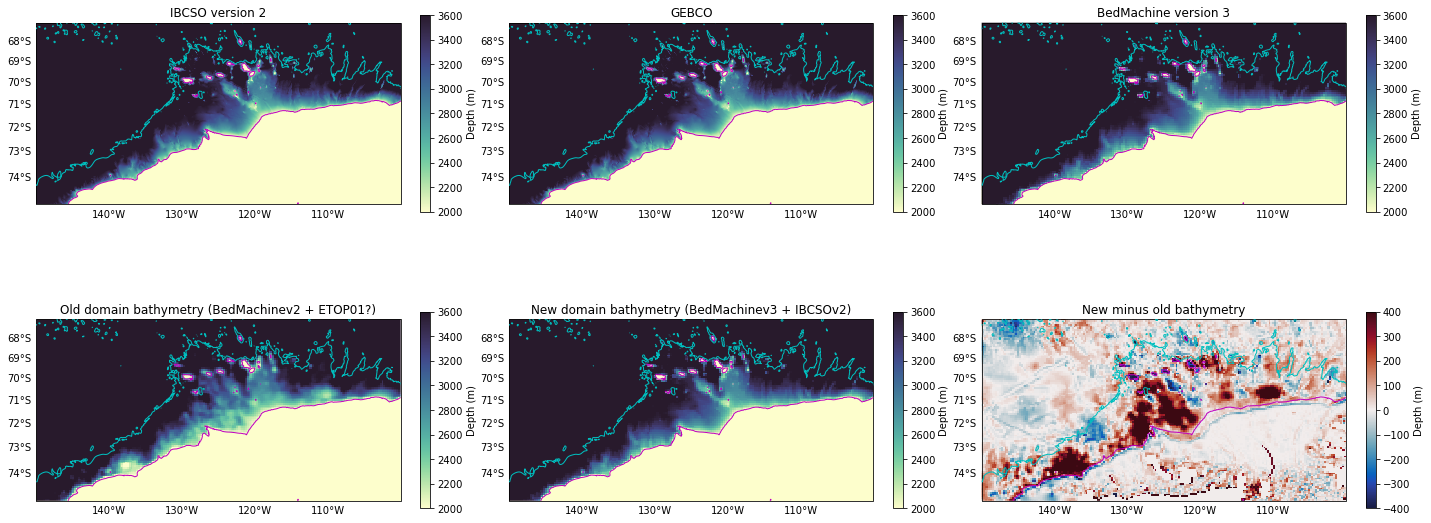

In [48]:
fig, ax = plt.subplots(2,3, figsize=(24,10), subplot_kw={'projection': ccrs.Mercator(latitude_true_scale=-70)})

vmin=2000
vmax=3600

for axis in ax.ravel():
    axis.set_extent([-100, -150, -75, -67], ccrs.PlateCarree())
    gl = axis.gridlines(draw_labels=True);
    gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;
    cs = axis.contour(IBCSOv2.lon, IBCSOv2.lat, -1*IBCSOv2.z, levels=[2000], 
                      colors='m', linestyles='-', linewidths=1, zorder=4, transform=ccrs.PlateCarree())
    cs = axis.contour(IBCSOv2.lon, IBCSOv2.lat, -1*IBCSOv2.z, levels=[4000], 
                      colors='c', linestyles='-', linewidths=1, zorder=4, transform=ccrs.PlateCarree())

kwags={'cmap':cmocean.cm.deep, 'vmin':vmin, 'vmax':vmax, 'transform':ccrs.PlateCarree()}

ax[0,0].set_title('IBCSO version 2', fontsize=12)
cm1 = ax[0,0].pcolormesh(IBCSOv2.lon, IBCSOv2.lat, -1*IBCSOv2.z, **kwags)
CB1 = fig.colorbar(cm1, ax=ax[0,0], fraction=0.025, label='Depth (m)')

ax[0,1].set_title('GEBCO', fontsize=12)
cm2 = ax[0,1].pcolormesh(GEBCO.lon[::2], GEBCO.lat[::2], -1*GEBCO.elevation[::2,::2], **kwags)
CB2 = fig.colorbar(cm2, ax=ax[0,1], fraction=0.025, label='Depth (m)')

ax[0,2].set_title('BedMachine version 3', fontsize=12)
cm3 = ax[0,2].pcolormesh(coord.nav_lon, coord.nav_lat, -1*BedMachine.bathy, **kwags)
CB3 = fig.colorbar(cm3, ax=ax[0,2], fraction=0.025, label='Depth (m)')

ax[1,0].set_title('Old domain bathymetry (BedMachinev2 + ETOP01?)', fontsize=12)
cm4 = ax[1,0].pcolormesh(coord.nav_lon, coord.nav_lat, domain_old.bathy_metry, **kwags)
CB4 = fig.colorbar(cm4, ax=ax[1,0], fraction=0.025, label='Depth (m)')

ax[1,1].set_title('New domain bathymetry (BedMachinev3 + IBCSOv2)', fontsize=12)
cm5 = ax[1,1].pcolormesh(coord.nav_lon, coord.nav_lat, domain_new.bathy_metry, **kwags)
CB5 = fig.colorbar(cm5, ax=ax[1,1], fraction=0.025, label='Depth (m)')

ax[1,2].set_title('New minus old bathymetry', fontsize=12)
cm6 = ax[1,2].pcolormesh(coord.nav_lon, coord.nav_lat, domain_diff, 
                         cmap=cmocean.cm.balance, vmin=-400, vmax=400, transform=ccrs.PlateCarree())
CB6 = fig.colorbar(cm6, ax=ax[1,2], fraction=0.025, label='Depth (m)')

fig.savefig('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/Amundsen_bathy_overview.jpg', dpi=400)

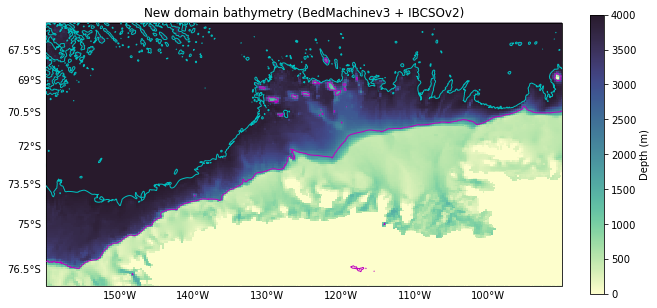

In [54]:
fig, ax = plt.subplots(1,1, figsize=(10,8), subplot_kw={'projection': ccrs.Mercator(latitude_true_scale=-70)})

vmin=0
vmax=4000
kwags={'cmap':cmocean.cm.deep, 'vmin':vmin, 'vmax':vmax, 'transform':ccrs.PlateCarree()}

ax.set_extent([-90, -160, -77, -66], ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True);
gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;
cs = ax.contour(IBCSOv2.lon, IBCSOv2.lat, -1*IBCSOv2.z, levels=[2000], 
                colors='m', linestyles='-', linewidths=1, zorder=4, transform=ccrs.PlateCarree())
cs = ax.contour(IBCSOv2.lon, IBCSOv2.lat, -1*IBCSOv2.z, levels=[4000], 
                colors='c', linestyles='-', linewidths=1, zorder=4, transform=ccrs.PlateCarree())

ax.set_title('New domain bathymetry (BedMachinev3 + IBCSOv2)', fontsize=12)
cm5 = ax.pcolormesh(coord.nav_lon, coord.nav_lat, domain_new.bathy_metry, **kwags)
CB5 = fig.colorbar(cm5, ax=ax, fraction=0.025, label='Depth (m)')

fig.savefig('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/Amundsen_bathy_new.jpg', dpi=400)